In [ ]:
!pip install tensorflow==2.14.1
!pip install tensorflow-estimator==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [ ]:
!pip install tensorflow-privacy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.
xarray 2024.9.0 requires packaging>=23.1, but you have packaging 22.0 which is incompatible.


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Process Data

In [ ]:
data  = pd.read_csv('/content/drive/MyDrive/RT_IOT2022.csv', index_col = 0)

In [ ]:
# Multiclass problem
target_column = 'Attack_type'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

In [ ]:
# Lets keep top 3 groups and implement imbalancing
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DOS_SYN_Hping','Thing_Speak','ARP_poisioning'])]

In [ ]:
# Add Upsampling
from imblearn.over_sampling import RandomOverSampler
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data['Attack_type'] = label_encoder.fit_transform(data['Attack_type'])

In [ ]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

Index(['proto', 'service'], dtype='object')


In [ ]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

# Reshape data for LSTM

#I now convert the scaled training set into a NP Arrays and then reshape it

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

X_valid_array = X_valid_scaled[categorical_columns].to_numpy()

X_valid_reshaped = X_valid_array.reshape(X_valid_array.shape[0], 1, X_valid_array.shape[1])

## PATE LSTM Default

In [ ]:
from keras.callbacks import EarlyStopping
# Early stopping (make patience bigger if stopping too early)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Define the input_shape variable
#input_shape = X_train_lstm.shape[1:]
input_shape=(1, len(categorical_columns))

def create_teacher_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def create_student_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model
# Define your hyperparameters
num_teachers = 1
epsilon = 1.0
kfolds = 2
num_epochs = 2
bs = 32

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=bs,
                          validation_data= (X_val_fold, y_val_fold),
                          callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return np.array(labels)  # Convert list of arrays to a single array

    # Define your student model
    student_model = create_student_model(input_shape, num_classes)

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    # train_labels = train_labels.reshape((-1, num_teachers, num_classes))
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model.fit(X_train_fold, student_y_train_fold, epochs=num_epochs, batch_size=bs, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.fit(X_train_lstm, y_train, epochs=num_epochs, batch_size=bs, validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return np.array(labels)  # Convert list of arrays to a single array

# Define your student model
student_model = create_student_model(input_shape, num_classes)

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_lstm)
# train_labels = train_labels.reshape((-1, num_teachers, num_classes))
student_train_labels = pd.Series(train_labels[0], index = y_train.index)

# Train the student model using the labels generated by the teacher models
model_history =student_model.fit(X_train_lstm, student_train_labels, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed


# # Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

# Predict on the test data
y_test_pred = student_model.predict(X_test_reshaped)

Epoch 1/2
3328/3328 [==============================] - 18s 5ms/step - loss: 0.4053 - accuracy: 0.8696 - val_loss: 0.1216 - val_accuracy: 0.9641
Epoch 2/2
3328/3328 [==============================] - 6s 2ms/step
Epoch 1/2
3311/3328 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8943

3328/3328 [==============================] - 12s 3ms/step - loss: 0.3654 - accuracy: 0.8947
Epoch 2/2
3328/3328 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9910

3328/3328 [==============================] - 6s 2ms/step - loss: 0.1163 - accuracy: 0.9784
Epoch 1/2
3328/3328 [==============================] - 20s 5ms/step - loss: 0.3949 - accuracy: 0.8966 - val_loss: 0.1223 - val_accuracy: 0.9681
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step
Epoch 1/2
3326/3328 [============================>.] - ETA: 0s - loss: 0.4028 - accuracy: 0.8794

3328/3328 [==============================] - 12s 3ms/step - loss: 0.4026 - accuracy: 0.8795
Epoch 2/2
3314/3328 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9881

3328/3328 [==============================] - 7s 2ms/step - loss: 0.1245 - accuracy: 0.9789
Epoch 1/2
5325/5325 [==============================] - 20s 3ms/step - loss: 0.2797 - accuracy: 0.9160 - val_loss: 0.0823 - val_accuracy: 0.9770
Epoch 2/2
6656/6656 [==============================] - 12s 2ms/step
Epoch 1/2
5325/5325 [==============================] - 20s 3ms/step - loss: 0.2576 - accuracy: 0.9295 - val_loss: 0.0343 - val_accuracy: 0.9901
Epoch 2/2
888/888 [==============================] - 2s 2ms/step


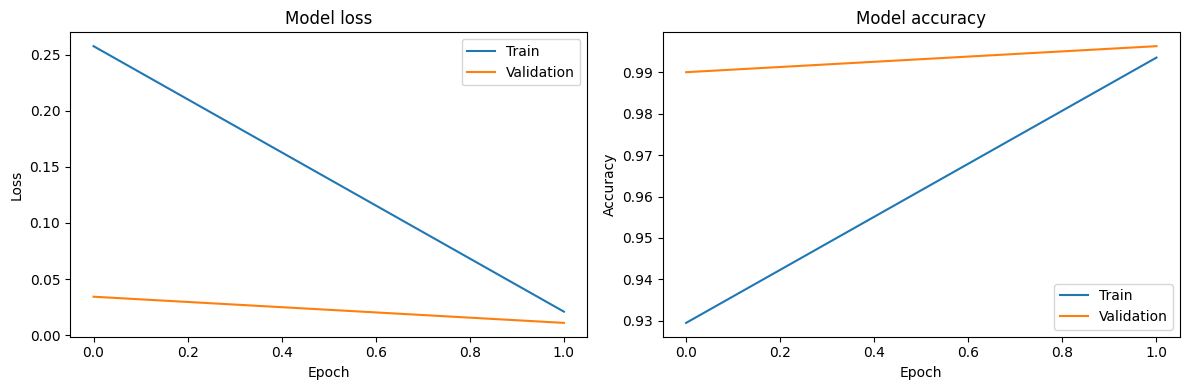

In [ ]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

In [ ]:
# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred, axis=1)

# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.12042267620563507
Average cross-validation accuracy: 0.9786085188388824
MLP Model:
Accuracy =  0.9813367138530883
Precision = 0.9814007886508936
Recall = 0.9814331114825011
F1 Score =  0.9813836739339664


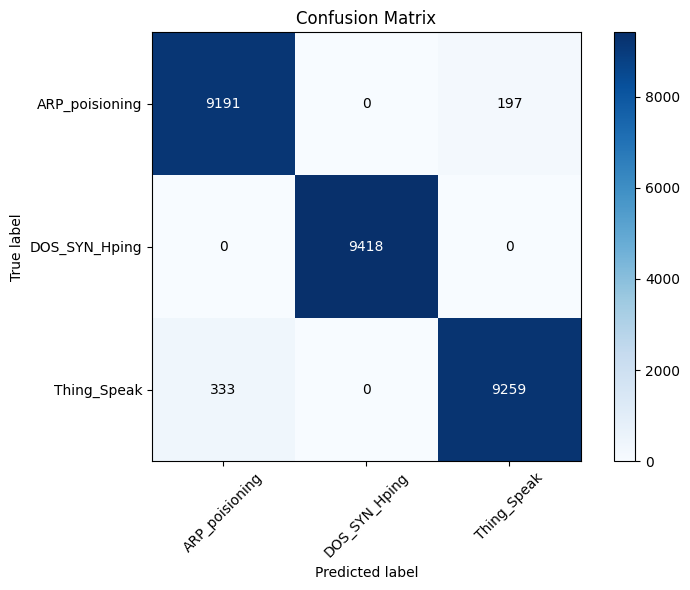

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

## PATE Privacy

In [ ]:
# Define the input_shape variable
#input_shape = X_train_lstm.shape[1:]
input_shape=(1, len(categorical_columns))

def create_teacher_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Set hyperparameters for privacy-preserving training
batch_size = 128  # Number of samples in each training batch
l2_norm_clip = 1.5  # Upper bound on the L2 norm of model's gradients
noise_multiplier = 1.3  # Multiplier for the Gaussian noise added to gradients
num_microbatches = 1  # Number of microbatches for training
learning_rate = 0.003  # Learning rate for the optimizer

# Ensure that batch size is a multiple of the number of microbatches
if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Initialize a differentially private stochastic gradient descent optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

def create_student_model_privacy(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(units=48, input_shape=input_shape))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=48, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model outside the loop if the architecture and optimizer are consistent
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define your hyperparameters
num_teachers = 1
epsilon = 1.0
kfolds = 2
num_epochs = 2
bs = 32

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Create and train teacher models for this fold
    teacher_models = []
    for i in range(num_teachers):
        teacher_model = create_teacher_model(input_shape, num_classes)
        teacher_model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=bs,
                          validation_data= (X_val_fold, y_val_fold) ,
                          callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
        teacher_models.append(teacher_model)

    # Generate labels for the training data using teacher models
    def generate_labels(data):
        labels = []
        for model in teacher_models:
            labels.append(np.argmax(model.predict(data), axis = 1))
        return np.array(labels)  # Convert list of arrays to a single array

    # Define your student model
    student_model_privacy = create_student_model_privacy(input_shape, num_classes)

    # Generate labels for the training data using teacher models
    train_labels = generate_labels(X_train_fold)
    # train_labels = train_labels.reshape((-1, num_teachers, num_classes))
    student_y_train_fold = pd.Series(train_labels[0], index = y_train_fold.index)

    # Train the student model using the labels generated by the teacher models
    student_model_privacy.fit(X_train_fold, student_y_train_fold, epochs=num_epochs, batch_size=bs,
                              callbacks=[early_stopping])  # Adjust epochs and batch_size as needed

    # Evaluate the student model on the validation set
    val_loss, val_accuracy = student_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit the full model on the entire training set
teacher_models = []
for i in range(num_teachers):
    teacher_model = create_teacher_model(input_shape, num_classes)
    teacher_model.fit(X_train_lstm, y_train, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed
    teacher_models.append(teacher_model)

# Generate labels for the training data using teacher models
def generate_labels(data):
    labels = []
    for model in teacher_models:
        labels.append(np.argmax(model.predict(data), axis = 1))
    return np.array(labels)  # Convert list of arrays to a single array

# Define your student model
student_model_privacy = create_student_model_privacy(input_shape, num_classes)

# Generate labels for the training data using teacher models
train_labels = generate_labels(X_train_lstm)
# train_labels = train_labels.reshape((-1, num_teachers, num_classes))
student_train_labels = pd.Series(train_labels[0], index = y_train.index)

# Train the student model using the labels generated by the teacher models
model_history_privacy = student_model_privacy.fit(X_train_lstm, student_train_labels, epochs=num_epochs, batch_size=bs,validation_split = 0.2, callbacks=[early_stopping])  # Adjust epochs and batch_size as needed


# # Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()


Epoch 1/2
3328/3328 [==============================] - 17s 5ms/step - loss: 0.2377 - accuracy: 0.9213 - val_loss: 0.0913 - val_accuracy: 0.9726
Epoch 2/2
3328/3328 [==============================] - 7s 2ms/step
Epoch 1/2
3326/3328 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.7587

3328/3328 [==============================] - 25s 4ms/step - loss: 0.5741 - accuracy: 0.7587
Epoch 2/2
3325/3328 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8964

3328/3328 [==============================] - 5s 2ms/step - loss: 0.0912 - accuracy: 0.9818
Epoch 1/2
3328/3328 [==============================] - 23s 6ms/step - loss: 0.2406 - accuracy: 0.9207 - val_loss: 0.0959 - val_accuracy: 0.9719
Epoch 2/2
3328/3328 [==============================] - 6s 2ms/step
Epoch 1/2
3325/3328 [============================>.] - ETA: 0s - loss: 0.5231 - accuracy: 0.7873

3328/3328 [==============================] - 24s 4ms/step - loss: 0.5229 - accuracy: 0.7874
Epoch 2/2
3319/3328 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8941

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0939 - accuracy: 0.9819
Epoch 1/2
5325/5325 [==============================] - 20s 3ms/step - loss: 0.1876 - accuracy: 0.9430 - val_loss: 0.0746 - val_accuracy: 0.9765
Epoch 2/2
6656/6656 [==============================] - 11s 2ms/step
Epoch 1/2
5325/5325 [==============================] - 39s 5ms/step - loss: 0.4480 - accuracy: 0.8230 - val_loss: 0.2122 - val_accuracy: 0.9470
Epoch 2/2
5325/5325 [==============================] - 23s 4ms/step - loss: 0.4516 - accuracy: 0.8719 - val_loss: 0.3250 - val_accuracy: 0.9245


In [ ]:
# Predict on the test data
y_test_pred_mlp_privacy = student_model_privacy.predict(X_test_reshaped)

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

888/888 [==============================] - 2s 2ms/step


In [ ]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.09252392500638962
Average cross-validation accuracy: 0.9818716943264008
MLP Model:
Accuracy =  0.9188675258821044
Precision = 0.9206875516257421
Recall = 0.9190352303509388
F1 Score =  0.919268459886204


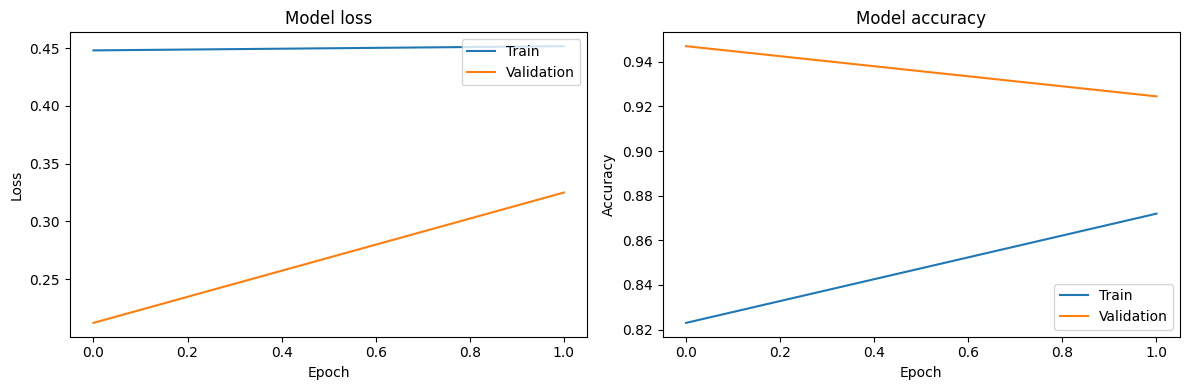

In [ ]:
# Plot loss curves
plot_loss(model_history_privacy)

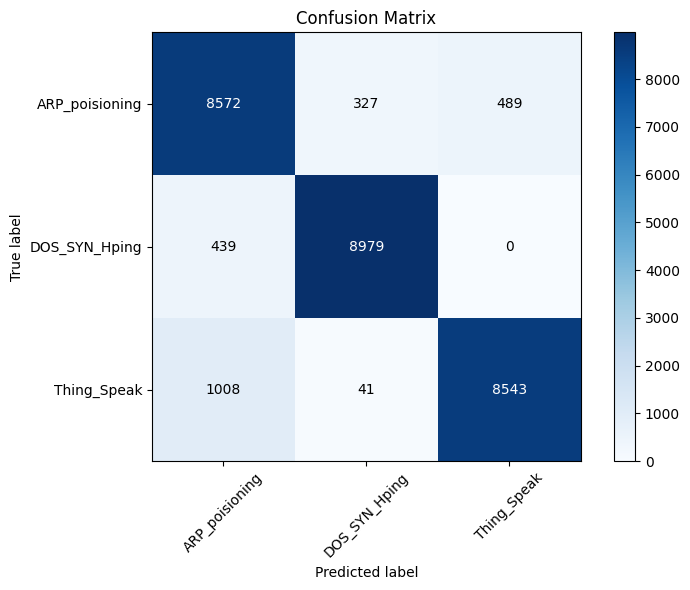

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [ ]:
# help(compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy)

In [ ]:
# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_lstm),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [ ]:
print(privacy_report)

DP-SGD performed over 212982 examples with 128 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      2.640

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine

In [ ]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.981337,0.918868
1,Precision,0.981401,0.920688
2,Recall,0.981433,0.919035
3,F1 Score,0.981384,0.919268


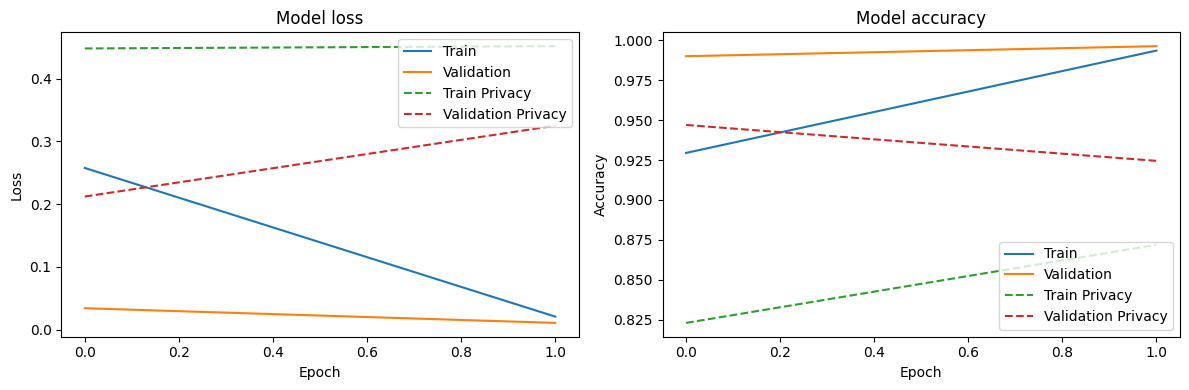

In [ ]:
plot_loss(model_history, model_history_privacy)